COVID/images 文件夹: 找到 3616 张图像
Normal/images 文件夹: 找到 10192 张图像
Viral Pneumonia/images 文件夹: 找到 1345 张图像
Lung_Opacity/images 文件夹: 找到 6012 张图像
总共找到 21165 张图像
Epoch 1/10


100%|██████████| 662/662 [01:00<00:00, 10.96it/s]


Generator loss: 0.9275, Discriminator loss: 1.3768


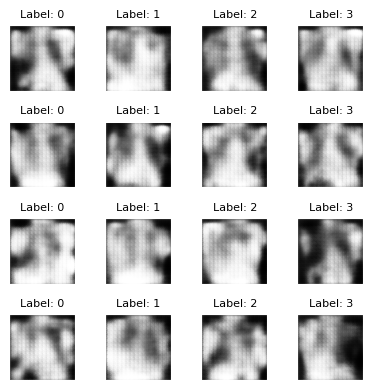

Epoch 2/10


100%|██████████| 662/662 [00:56<00:00, 11.79it/s]


Generator loss: 1.0082, Discriminator loss: 1.5353


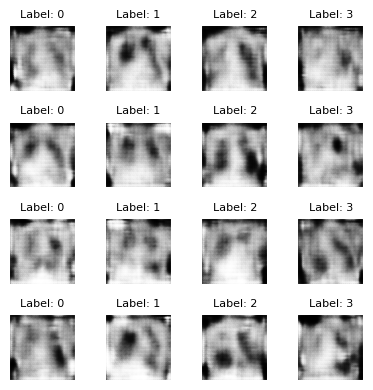

Epoch 3/10


100%|██████████| 662/662 [00:55<00:00, 11.97it/s]


Generator loss: 1.1247, Discriminator loss: 0.8937


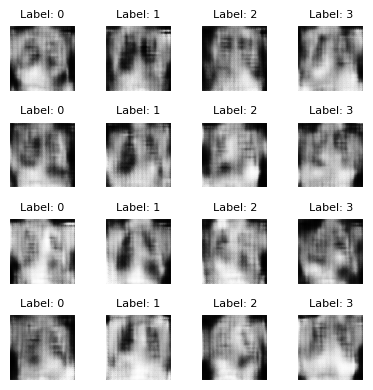

Epoch 4/10


100%|██████████| 662/662 [00:55<00:00, 11.95it/s]


Generator loss: 1.4159, Discriminator loss: 1.2219


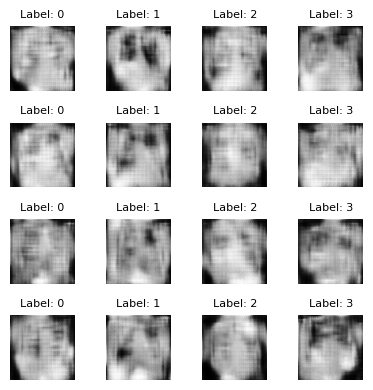

Epoch 5/10


100%|██████████| 662/662 [00:55<00:00, 11.99it/s]


Generator loss: 3.3812, Discriminator loss: 0.2990


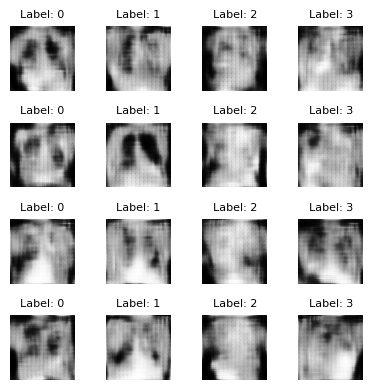

Epoch 6/10


100%|██████████| 662/662 [00:55<00:00, 12.03it/s]


Generator loss: 1.4349, Discriminator loss: 0.9886


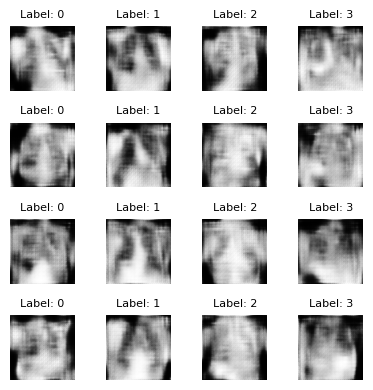

Epoch 7/10


100%|██████████| 662/662 [00:54<00:00, 12.23it/s]


Generator loss: 1.4744, Discriminator loss: 0.9094


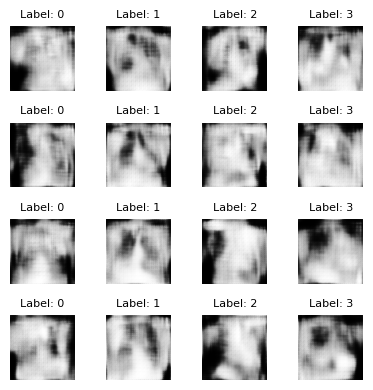

Epoch 8/10


100%|██████████| 662/662 [00:54<00:00, 12.25it/s]


Generator loss: 1.0862, Discriminator loss: 1.0541


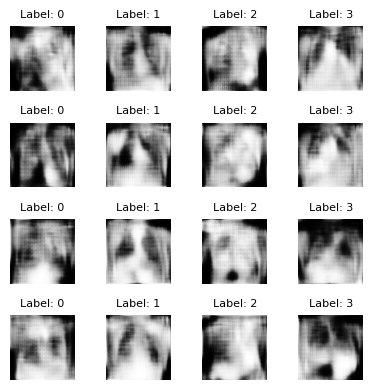

Epoch 9/10


100%|██████████| 662/662 [00:54<00:00, 12.15it/s]


Generator loss: 1.1315, Discriminator loss: 1.1171


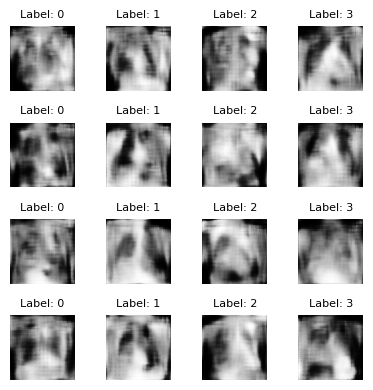

Epoch 10/10


100%|██████████| 662/662 [00:54<00:00, 12.16it/s]


Generator loss: 1.6981, Discriminator loss: 0.8518


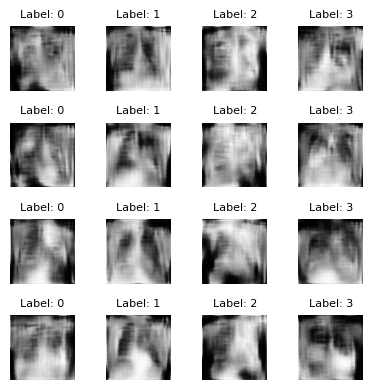

In [13]:
import os
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

data_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/'

files = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']
all_images = []
all_labels = []

for idx, file in enumerate(files):
    category_folder = os.path.join(data_dir, file, 'images')
    images = glob(os.path.join(category_folder, '*.png'))
    all_images.extend(images)
    all_labels.extend([idx] * len(images)) 
    print(f"{file}/images 文件夹: 找到 {len(images)} 张图像")
print(f"总共找到 {len(all_images)} 张图像")

IMG_SIZE = 128
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image - 127.5) / 127.5  
    label = tf.one_hot(label, depth=len(files))  
    return image, label

dataset = tf.data.Dataset.from_tensor_slices((all_images, all_labels))
dataset = dataset.map(load_and_preprocess_image).batch(32).shuffle(buffer_size=1024)

train_size = int(0.8 * len(all_images))
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

def build_generator():
    noise_input = layers.Input(shape=(100,))
    label_input = layers.Input(shape=(len(files),)) 

    x = layers.Concatenate()([noise_input, label_input])
    x = layers.Dense(16 * 16 * 256, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Reshape((16, 16, 256))(x)
    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    return models.Model([noise_input, label_input], x)

def build_discriminator():
    image_input = layers.Input(shape=(128, 128, 1))
    label_input = layers.Input(shape=(len(files),))  

    label = layers.Reshape((1, 1, len(files)))(label_input)
    label = layers.UpSampling2D(size=(128, 128))(label)

    x = layers.Concatenate()([image_input, label])
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)

    return models.Model([image_input, label_input], x)

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
sample_labels = tf.one_hot(np.arange(num_examples_to_generate) % len(files), depth=len(files))
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([images.shape[0], noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for image_batch, label_batch in tqdm(dataset):
            gen_loss, disc_loss = train_step(image_batch, label_batch)
        print(f"Generator loss: {gen_loss:.4f}, Discriminator loss: {disc_loss:.4f}")
        generate_and_save_images(generator, epoch + 1, seed, sample_labels)
def generate_and_save_images(model, epoch, test_input, test_labels):
    predictions = model([test_input, test_labels], training=False)
    fig = plt.figure(figsize=(4, 4))
    decoded_labels = np.argmax(test_labels, axis=1)
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        plt.title(f"Label: {decoded_labels[i]}", fontsize=8)
    plt.tight_layout()
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()
train(train_dataset, EPOCHS)
